In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.metrics import roc_auc_score, roc_curve

## Load data

In [3]:
df_predictors = pd.read_pickle('../data/external/df_predictors.pkl')
s_dp = df_predictors.dp.asfreq('M')
s_ret = df_predictors['Index'].pct_change().asfreq('M')

In [4]:
div_yield = s_dp.diff()[s_dp.index.year >= 1980]
returns = s_ret[s_ret.index.year >= 1980]

In [5]:
series = returns

## Generate Data

In [6]:
Y = np.concatenate((np.random.randn(100),np.random.randn(100)*2+2,np.random.randn(100)*2-2))

In [7]:
Y = np.random.randn(20)

In [8]:
Y = np.array([])
for i in range(2):
    Y = np.concatenate((Y,np.random.randn(10)*2+2))
    Y = np.concatenate((Y,np.random.randn(10)))

In [9]:
Y = np.array([])
for i in range(10):
    Y = np.concatenate((Y,np.random.randn(20)*2+2))
    Y = np.concatenate((Y,np.random.randn(20)))
    Y = np.concatenate((Y,np.random.randn(20)*2-2))

In [10]:
Y = np.array(returns)

In [30]:
Y = np.array(div_yield)

## Class HMM

In [11]:
class HMM:
    
    def __init__(self, emission_models=(), transition_matrix=None, start_probas=None):
        '''OK'''
        self.emission_models = emission_models
        self.transition_matrix = transition_matrix
        self.start_probas = start_probas
        
    def _check(self, A, pi, models):
        '''OK'''
        assert len(models) == A.shape[0] == A.shape[1] == pi.shape[1], 'dimension mismatch'
    
    @property
    def steady_state(self):
        '''FIX'''
        k = self.transition_matrix.shape[0]
        steady_state = np.full(k, 1/k).reshape(1, -1) @ self.transition_matrix
        return steady_state
        
    def _initialise_baum_welch(self, Y):
        '''FIX'''
        if self.start_probas is None:
            self.start_probas = self.steady_state
        
        A = np.array(self.transition_matrix)
        models = self.emission_models
        pi = np.array(self.start_probas).reshape(1, -1)
        return A, pi, models
    
    def _evaluate_emission_models(self, Y, emission_models):
        '''OK'''
        B = np.concatenate([model.pdf(Y).reshape(-1, 1) for model in emission_models], axis=1)
        return B
        
    def _forward_pass(self, A, B, pi):
        '''OK'''
        # initialise forward pass with first observation
        alpha_0 = pi * B[0]
        c_0 = 1/alpha_0.sum()
        
        # save values & scaling factor
        Alpha = alpha_0*c_0
        C = [c_0]
        
        # iterate
        for b_t in B[1:]:
            # calculate
            alpha_t = (b_t * Alpha[-1] @ A).reshape(1, -1)
            c_t = 1/alpha_t.sum()
            
            # save
            Alpha = np.concatenate((Alpha, alpha_t*c_t), axis=0)
            C += [c_t]
            
        C = np.array(C).reshape(-1, 1)
        return Alpha, C
            
    def _backward_pass(self, A, B, pi, C):
        '''OK'''
        # initialise backward pass as one
        beta_T = np.ones(pi.shape)
        
        # save values & scaling factor
        Beta = beta_T*C[-1]
        
        # iterate
        for b_t, c_t in zip(B[:0:-1],C[len(C)-2::-1]):
            # calculate
            beta_t = (b_t * Beta[0] @ A.T).reshape(1, -1)
            
            # save
            Beta = np.concatenate((beta_t*c_t, Beta), axis=0)
            
        return Beta
    
    def _emission_odds(self, Alpha, Beta):
        '''OK'''
        total = Alpha * Beta
        Gamma = total/total.sum(axis=1).reshape(-1, 1)
        return Gamma
    
    def _transition_odds(self, A, B, Alpha, Beta):
        '''OK'''
        Alpha_block = np.kron(Alpha[:-1], np.ones(A.shape[0]))
        B_Beta_block = np.kron(np.ones(A.shape[0]), B[1:]*Beta[1:])
        total = Alpha_block * B_Beta_block * A.reshape(1, -1)
        Xi = total/total.sum(axis=1).reshape(-1, 1)
        return Xi
        
    def _do_e_step(self, Y, A, B, pi):
        '''OK'''
        Alpha, C = self._forward_pass(A, B, pi)
        Beta = self._backward_pass(A, B, pi, C)
        Gamma = self._emission_odds(Alpha, Beta)
        Xi = self._transition_odds(A, B, Alpha, Beta)
        return Alpha, Gamma, Xi
    
    def _update_transition_matrix(self, Gamma, Xi):
        '''OK'''
        numerator = Xi.sum(axis=0)
        denominator = np.kron(Gamma[:-1], np.ones(Gamma.shape[1])).sum(axis=0)
        A_ = (numerator/denominator).reshape(Gamma.shape[1], Gamma.shape[1])
        return A_
    
    def _update_parameters(self, Y, emission_models, Gamma):
        '''OK'''
        models_ = []
        for model, weights in zip(emission_models, Gamma.T):
            model.fit(Y, weights)
            models_ += [model]
        return tuple(models_)
    
    def _update_initial_state(self, Gamma):
        '''OK'''
        return Gamma[0].reshape(1, -1)
    
    def _do_m_step(self, Y, models, Gamma, Xi):
        '''OK'''
        A_ = self._update_transition_matrix(Gamma, Xi)
        models_ = self._update_parameters(Y, models, Gamma)
        pi_ = self._update_initial_state(Gamma)
        return A_, models_, pi_
    
    def _score(self, Y, emission_models, Gamma):
        '''OK'''
        B = self._evaluate_emission_models(Y, emission_models)
        score = np.log((B * Gamma).sum(axis=1)).sum(axis=0)
        return score, B
    
    def _update_attributes(self, A_, models_, pi_, Gamma, Alpha):
        '''OK'''
        self.transition_matrix = A_
        self.emission_models = models_
        self.start_probas = pi_
        self.smooth_prob_ = Gamma
        self.filt_prob_ = Alpha
    
    def _estimate_baum_welch(self, Y, max_iter=100, threshold=1e-6):
        '''OK'''
        # initialise
        A_, pi_, models_ = self._initialise_baum_welch(Y)
        self._check(A_, pi_, models_)
        score_, B_ = self._score(Y, models_, pi_)
        
        # store
        iteration = 0
        scores = {iteration: score_}
        
        while iteration < max_iter:
            iteration += 1
            Alpha, Gamma, Xi = self._do_e_step(Y, A_, B_, pi_)            
            A_, models_, pi_ = self._do_m_step(Y, models_, Gamma, Xi)
            score_, B_ = self._score(Y, models_, Gamma)
            scores[iteration] = score_
            
            if abs(scores[iteration]-scores[iteration-1]) < threshold:
                break
        else:
            warnings.warn('maximum number of iterations reached')
                
        self._update_attributes(A_, models_, pi_, Gamma, Alpha)
        self.convergence_ = scores
        
        return self
            
    def fit(self, Y, method='baumwelch', **kwargs):
        '''OK'''
        assert method in ['baumwelch'], 'method unknown'
        
        if method == 'baumwelch':
            self = self._estimate_baum_welch(Y, **kwargs)

In [12]:
class NormalModel:
    def __init__(self, mu=0, sigma=1):
        self.mu = mu
        self.sigma = sigma
        
    def fit(self, Y, weights=None):
        '''fits the model parameters to an observation sequence, weights are optional'''
        # prepare
        Y = np.array(Y).reshape(-1, 1)
        if weights is None:
            weights = np.ones(Y.shape)
        else:
            weights = np.array(weights).reshape(-1, 1)
        
        # estimate mean
        mean = (Y*weights).sum(axis=0)/weights.sum(axis=0)
        
        # estimate variance
        errors = (Y-mean)**2
        variance = (errors*weights).sum(axis=0)/weights.sum(axis=0)
        
        # update
        self.mu = mean
        self.sigma = np.sqrt(variance)
        
    def pdf(self, Y):
        '''returns the likelihood of each observation in an observation sequence'''
        pdf = 1/(self.sigma * np.sqrt(2*np.pi)) * np.exp(-0.5*(Y-self.mu)**2/self.sigma**2)
        return pdf
    
    def score(self, Y):
        '''returns the log-likelihood of an observation sequence'''
        score = np.log(self.pdf(Y)).sum()
        return score

## Two-State Model

CPU times: user 594 ms, sys: 15.6 ms, total: 609 ms
Wall time: 644 ms


<AxesSubplot:>

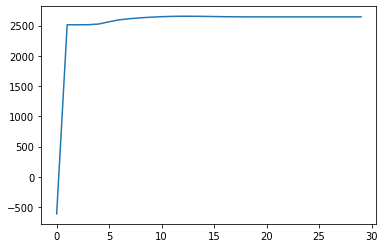

In [31]:
%%time
test = HMM()
test.start_probas = np.array([[0.4, 0.6]])
test.transition_matrix = np.array([[0.8, 0.2],[0.2, 0.8]])
test.emission_models = (NormalModel(mu=0, sigma=1), NormalModel(mu=-0.05, sigma=2))

# A, pi, models = test._initialise_baum_welch(Y)
# score, B = test._score(Y, models, pi)

# #print(test._score(Y, models, Gamma))

# Alpha_0, C = test._forward_pass(A,B,pi)
# Beta_0 = test._backward_pass(A,B,pi,C)
# Gamma_0 = test._emission_odds(Alpha_0, Beta_0)
# Xi_0 = test._transition_odds(A, B, Alpha_0, Beta_0)

# Alpha, Gamma, Xi = test._do_e_step(Y, A, B, pi)

# #pi_0 = test._update_initial_state(Gamma)
# #A_0 = test._update_transition_matrix(Gamma, Xi)
# #models_0 = test._update_parameters(Y, models, Gamma)

# A_, models_, pi_ = test._do_m_step(Y, models, Gamma, Xi)

# score_, B_ = test._score(Y, models_, pi_)

# Alpha, Gamma, Xi = test._do_e_step(Y, A_, B_, pi_)

# #score = test._score(Y, models_, Gamma)
test = test._estimate_baum_welch(Y, max_iter=1000)

pd.Series(test.convergence_).plot()

In [32]:
test.fit(Y, max_iter=200)

In [39]:
test.transition_matrix

array([[0.99665808, 0.00334192],
       [0.01082206, 0.98917794]])

In [33]:
[(m.mu, m.sigma**2) for m in test.emission_models]

[(array([-4.04925164e-05]), array([4.74908975e-07])),
 (array([-0.00012767]), array([3.82083783e-06]))]

In [34]:
test._score(Y, test.emission_models, test.smoothened_probabilities)[0]

2642.8119194970695

In [44]:
import sys
sys.path.append('../')
from src.hmm import HMM as HMMpack

In [40]:
%%time
hmm = HMMpack(switch_var=True, k=2)
hmm = hmm.fit(pd.Series(Y), package='hmmlearn', iter=100)
hmm.params_

CPU times: user 156 ms, sys: 15.6 ms, total: 172 ms
Wall time: 94.4 ms


p[0->0]      0.499740
p[1->0]      0.499740
const[0]    -0.000071
const[1]    -0.000072
sigma2[0]    0.000043
sigma2[1]    0.000043
dtype: float64

In [38]:
hmm.metrics_

llf    1960.862288
aic   -3909.724577
bic   -3884.681860
dtype: float64

<AxesSubplot:>

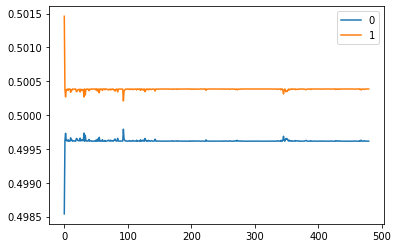

In [41]:
(hmm.smooth_prob_).plot()

In [21]:
test.transition_matrix.round(4)

array([[0.9671, 0.0329],
       [0.0261, 0.9739]])

<AxesSubplot:>

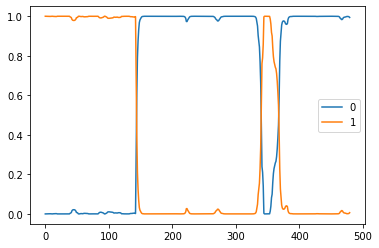

In [42]:
S = pd.DataFrame(test.smoothened_probabilities)
S.plot()

<AxesSubplot:>

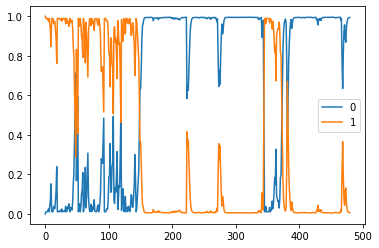

In [43]:
F = pd.DataFrame(test.filtered_probabilities)
F.plot()

## Three-State Model

CPU times: user 4.72 s, sys: 31.2 ms, total: 4.75 s
Wall time: 4.73 s


<AxesSubplot:>

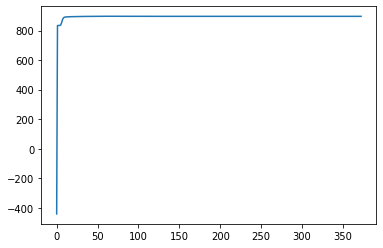

In [24]:
%%time
test = HMM()
test.start_probas = np.array([[0.2, 0.3, 0.5]])
test.transition_matrix = np.array([[0.72, 0.03, 0.25],[0.06, 0.90, 0.04],[0.22, 0.7, 0.08]])
#test.transition_matrix = np.array([[0.8,0.1,0.1],[0.1,0.8,0.1],[0.1,0.1,0.8]])
test.emission_models = (NormalModel(mu=-0.02, sigma=0.25), NormalModel(mu=0.02, sigma=0.25), NormalModel(mu=0.07, sigma=0.25))
test.emission_models = (NormalModel(mu=-0.02, sigma=1), NormalModel(mu=0.02, sigma=1), NormalModel(mu=0.0, sigma=1))

test = test._estimate_baum_welch(Y, max_iter=1000)

pd.Series(test.convergence_).plot()

In [25]:
test.transition_matrix.round(2)

array([[0.64, 0.  , 0.36],
       [0.03, 0.97, 0.  ],
       [0.46, 0.06, 0.48]])

In [26]:
[(m.mu,m.sigma) for m in test.emission_models]

[(array([0.00520445]), array([0.05108365])),
 (array([0.01134662]), array([0.02602925])),
 (array([0.00600311]), array([0.05215226]))]

<AxesSubplot:>

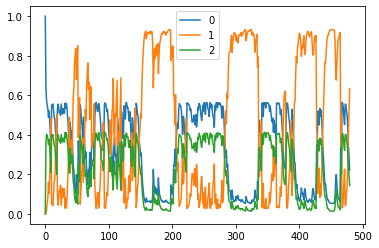

In [27]:
F = pd.DataFrame(test.filtered_probabilities)
F.plot()

<AxesSubplot:>

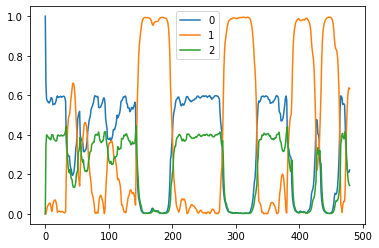

In [28]:
S = pd.DataFrame(test.smoothened_probabilities)
S.plot()

## Four-State Model

CPU times: user 5.22 s, sys: 172 ms, total: 5.39 s
Wall time: 5.5 s


<AxesSubplot:>

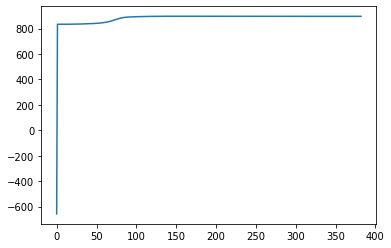

In [29]:
%%time
test = HMM()
test.start_probas = np.array([[0.25, 0.25, 0.25, 0.25]])
test.transition_matrix = np.array([[0.3, 0.4, 0.3, 0],[0.3, 0.4, 0, 0.3],[0.3, 0, 0.4, 0.3],[0.25,0.25,0.25,0.5]])
test.emission_models = (NormalModel(mu=0, sigma=1), NormalModel(mu=1, sigma=1),NormalModel(mu=-1, sigma=1),NormalModel(mu=0, sigma=3))

test = test._estimate_baum_welch(Y, max_iter=1000)

pd.Series(test.convergence_).plot()